<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Mads/AML_IceCores_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [4]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [5]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [6]:
train_size = len(train.labels)
test_size = len(test.labels)

In [7]:
'''# create encoder training
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
for i in range(nr_ims):
    im, lab, feat = train.__getitem__(i)
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

# create testing
x_test = []
x_test_lab = []
x_test_feats = []
nr_ims = 10000
for i in range(nr_ims):
    im, lab, feat = test.__getitem__(i)
    x_test.append(im)
    x_test_lab.append(lab)
    x_test_feats.append(feat)
x_test = np.array(x_test)
x_test_lab = np.array(x_test_lab)
x_test_feats = np.array(x_test_feats)'''

'# create encoder training\nx_train = []\nx_train_lab = []\nx_train_feats = []\nnr_ims = 10000 # 10-15k images are the max we can load with the memory we have\nfor i in range(nr_ims):\n    im, lab, feat = train.__getitem__(i)\n    x_train.append(im)\n    x_train_lab.append(lab)\n    x_train_feats.append(feat)\nx_train = np.array(x_train)\nx_train_lab = np.array(x_train_lab)\nx_train_feats = np.array(x_train_feats)\n\n# create testing\nx_test = []\nx_test_lab = []\nx_test_feats = []\nnr_ims = 10000\nfor i in range(nr_ims):\n    im, lab, feat = test.__getitem__(i)\n    x_test.append(im)\n    x_test_lab.append(lab)\n    x_test_feats.append(feat)\nx_test = np.array(x_test)\nx_test_lab = np.array(x_test_lab)\nx_test_feats = np.array(x_test_feats)'

In [8]:
CNN_input = keras.Input(shape=(image_size, image_size, 1))
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(CNN_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128*2, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
CNN_output = keras.layers.Dense(7, activation='softmax')(x)

CNN_model = keras.Model(CNN_input, CNN_output, name='CNN_model')

CNN_model.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

CNN_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 64)        640       
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 128)       0         
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
'''CNN_model.fit(x_train, x_train_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])'''
train_increment = 5000
nr_trains = train_size//train_increment
#nr_trains_h = nr_trains//2
nr_trains=5
points_left_over = train_size % train_increment

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

index_count = 0
for i in range(nr_trains):
  print(i, nr_trains)
  x_im = []
  x_lab = []
  #x_feat = []
  for j in range(train_increment):
    im, lab, feat = train.__getitem__(index_count)
    index_count += 1
    x_im.append(im)
    x_lab.append(lab)
    #x_feat.append(feat)

  x_im = np.array(x_im)
  x_lab = np.array(x_lab)
  #x_feat = np.array(x_feat)

  CNN_model.fit(x_im, x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

  x_im = 0
  x_lab = 0
  x_feat = 0

x_im = 0
x_lab = 0
x_feat = 0

0 5
Epoch 1/200
141/141 [==============================] - 16s 26ms/step - loss: 1.1363 - accuracy: 0.6253 - val_loss: 0.8667 - val_accuracy: 0.7080
Epoch 2/200
141/141 [==============================] - 3s 23ms/step - loss: 0.8347 - accuracy: 0.7218 - val_loss: 0.7969 - val_accuracy: 0.7280
Epoch 3/200
141/141 [==============================] - 3s 23ms/step - loss: 0.7060 - accuracy: 0.7529 - val_loss: 0.8215 - val_accuracy: 0.7280
Epoch 4/200
141/141 [==============================] - 3s 23ms/step - loss: 0.6996 - accuracy: 0.7549 - val_loss: 0.6686 - val_accuracy: 0.7600
Epoch 5/200
141/141 [==============================] - 3s 23ms/step - loss: 0.6229 - accuracy: 0.7749 - val_loss: 1.0240 - val_accuracy: 0.6940
Epoch 6/200
141/141 [==============================] - 3s 23ms/step - loss: 0.5544 - accuracy: 0.7944 - val_loss: 0.7546 - val_accuracy: 0.7420
Epoch 7/200
141/141 [==============================] - 3s 23ms/step - loss: 0.5412 - accuracy: 0.8040 - val_loss: 0.5922 - val_accu

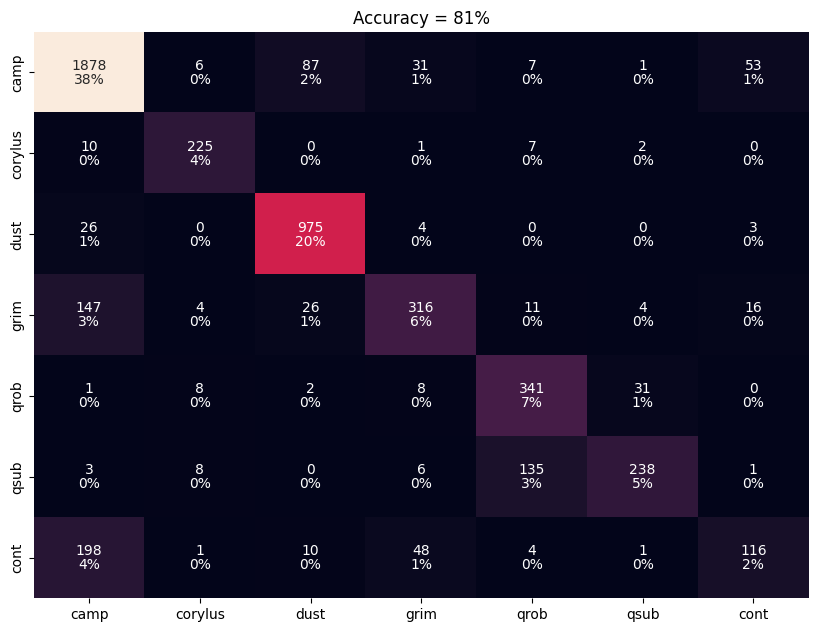

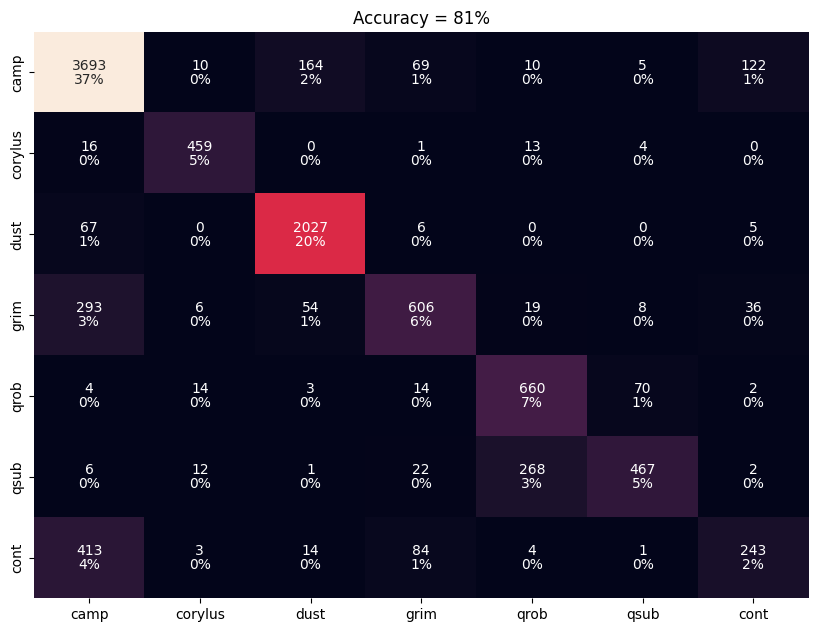

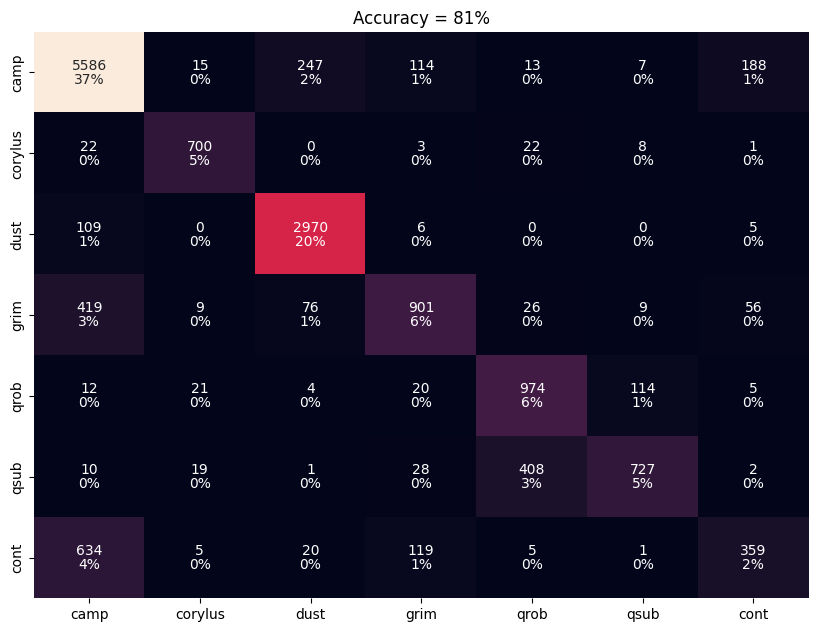

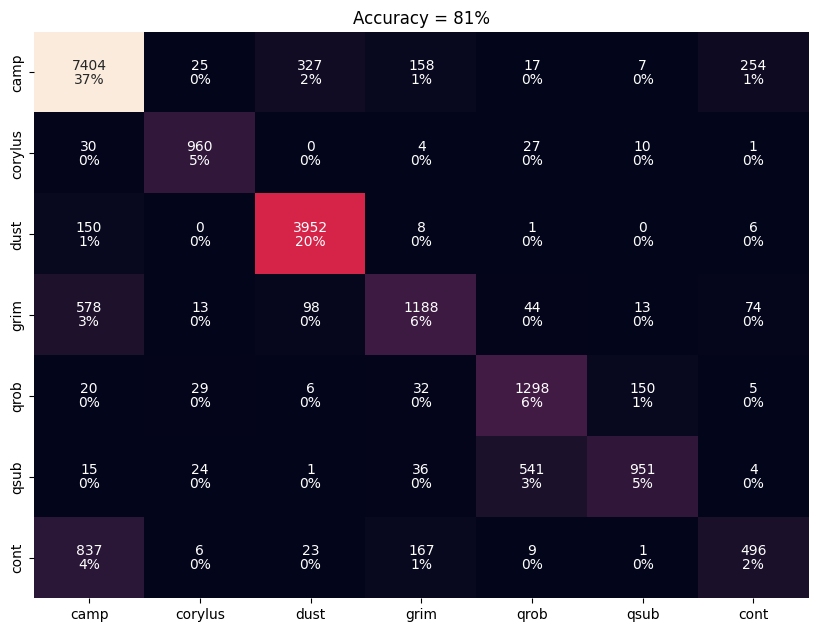

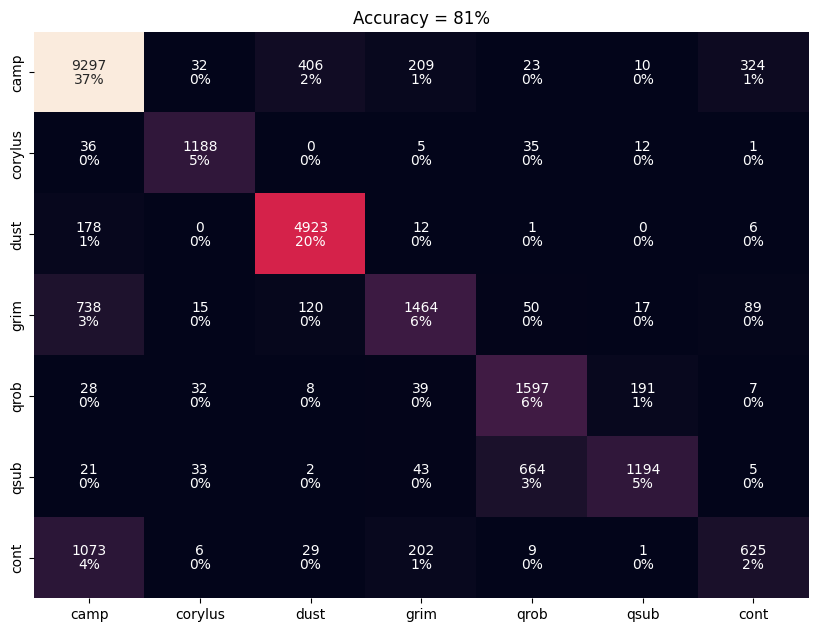

In [10]:
from sklearn.metrics import confusion_matrix
test_increment = 5000
nr_tests = test_size//test_increment
#nr_trains=1
points_left_over = test_size % test_increment

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

all_preds = np.array([])
all_labs = np.array([])

index_count = 0
for i in range(nr_tests):
  x_im = []
  x_lab = []
  #x_feat = []
  for j in range(train_increment):
    im, lab, feat = test.__getitem__(index_count)
    index_count += 1
    x_im.append(im)
    x_lab.append(lab)
    #x_feat.append(feat)

  x_im = np.array(x_im)
  x_lab = np.array(x_lab)
  #x_feat = np.array(x_feat)

  preds = np.argmax(CNN_model.predict(x_im), axis=1)

  all_preds = np.append(all_preds, preds)
  all_labs = np.append(all_labs, x_lab)

  x_im = 0
  x_lab = 0
  x_feat = 0

  acc = sum(all_preds==all_labs)/len(all_labs) *100

  cm = confusion_matrix(all_labs, all_preds)
  cm_perc = cm/np.sum(cm)

  types = ['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub', 'cont']

  plt.figure(figsize=(10,7.5),dpi=100)
  plt.title('Accuracy = ' + str(int(acc)) + '%')
  sb.heatmap(cm, annot=False, cbar=False, xticklabels=types, yticklabels=types)
  sb.heatmap(cm, annot=True, annot_kws={'va':'bottom'}, fmt="", cbar=False, xticklabels=types, yticklabels=types)
  sb.heatmap(cm, annot=cm_perc, annot_kws={'va':'top'}, fmt=".0%", cbar=False, xticklabels=types, yticklabels=types)
  plt.savefig('CNN_confusion.png')